In [ ]:
# !pip install torchviz
# import torchviz

In [ ]:
# IMPORTS -----------------#
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


# GENERATING POINTS ----------------------------------#
def concept(x, num):
    if num == 0:
        return 4*x-4*x**2
    elif num == 1:
        return x**2
    else:
        return x*(3*x-2)**2

def gen_coordinates(assignment, X_tensor):
    Y = concept(X_tensor, assignment).astype(np.double)
    return Y


# CONSTANTS ------------------------------------------------#
NUM_COORDINATES = 500
EPOCHS = 4000
X_learn = np.random.rand(NUM_COORDINATES, 1).astype(np.double)   # Training: randomly generated x values
X_tensor = torch.tensor(X_learn,dtype=torch.float32)
X_TEST = np.random.rand(NUM_COORDINATES, 1).astype(np.double)    # Testing: randomly generated x values
X_TEST_tensor = torch.tensor(X_TEST,dtype=torch.float32)
Y_learn=gen_coordinates(1, X_learn)                              # Training: corresponding y values for x values
Y_tensor = torch.tensor(Y_learn,dtype=torch.float32)


# STUDENT CLASS ------------------------------------------------------#
class Student(nn.Module):
    def __init__(self, neurons: int=3,activationfunc="relu"):
        super(Student, self).__init__()
        if activationfunc=="relu":
          self.activationfunc = nn.ReLU()
        else:
          self.activationfunc = nn.Sigmoid()
        self.layers=nn.Sequential(
            nn.Linear(1,neurons),self.activationfunc,nn.Linear(neurons,1)
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
# PLOTTING FUNCTION-------------------------------------------#
def plot_tests(trained_models,X):
  Y = concept(X, 1).astype(np.double)
  # Y_tensor = torch.tensor(Y,dtype=torch.float32)
  X_tensor = torch.tensor(X,dtype=torch.float32)

  fig, ax = plt.subplots(
    groups, len(trained_models)//groups,
    figsize=(8,12),
  )
  # ITERATING THROUGH TRAINED STUDENTS
  for group_num in range(0,len(trained_models),groups):
      colors = ['rx','gx','bx','mx']
      for i in range(groups):
        count = i+group_num
        Y_pred = trained_models[group_num+i].forward(X_tensor)
        Y_pred_nd = Y_pred.detach().numpy()
        ax[group_num//groups,i].plot(X, Y, 'x');
        ax[group_num//groups,i].plot(X, Y_pred_nd, colors[0]);
        ax[group_num//groups,i].set_ylim(bottom=0,top=1);

In [ ]:
# ACTIVE LEARNING------------------------------------------------------------#
def active_learning(students, groups, EPOCHS):
  assert(students%groups == 0)
  roster = []

  for group_number in range(0,students,groups):
    for student in range(groups):
      roster.append(Student())

  loss_fn = nn.MSELoss()

  optimizers = []

  # INITIALIZING OPTIMIZERS
  for group_number in range(0,students,groups):
      for student in range(groups):
        optimizers.append(optim.Adam(roster
        [group_number + student].parameters(), lr=0.01))
    # INITIALIZING STUDENTS
  for epoch in range(EPOCHS):
    outputs = []
    for group_number in range(0,students,groups):
      for student in range(groups):
        outputs.append(roster[group_number+student].forward(X_tensor))

      shared_loss = 0
      for student in range(groups):
        shared_loss += loss_fn(outputs[group_number+student], Y_tensor)

      for student in range(groups):
        optimizers[group_number+student].zero_grad()

      shared_loss/=students
      shared_loss.backward()

      for student in range(groups):
        optimizers[group_number+student].step()
      if epoch % 100 == 0:
        print(f'Epoch {epoch}, Shared Loss: {shared_loss.item()}')
  return roster

In [ ]:
#LECTURE LEARNING -----------------------------------------------------------
def training(model, in_tensor, target_tensor, optimizer):
  output = model(in_tensor)
  loss = loss_fn(output, target_tensor)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  return loss.item()

students = 36
losses = []
for i in range(10):
  # STUDENTS
  roster = []
  for i in range(students):
    roster.append(Student())

  # LOSS
  loss_fn = nn.MSELoss()

  # OPTIMIZERS
  optimizers = []
  for i in range(students):
    optimizers.append(optim.SGD(roster[i].parameters(), lr=0.01))


  for epoch in range(EPOCHS):  # Train for 100 epochs
    for i in range(students):
      l1 = training(roster[i],X_tensor, Y_tensor, optimizers[i])
      if epoch > 0 and epoch % EPOCHS == 0:
          print(f'Epoch {epoch}, Individual Loss: {l1}')
          losses.append(l1)


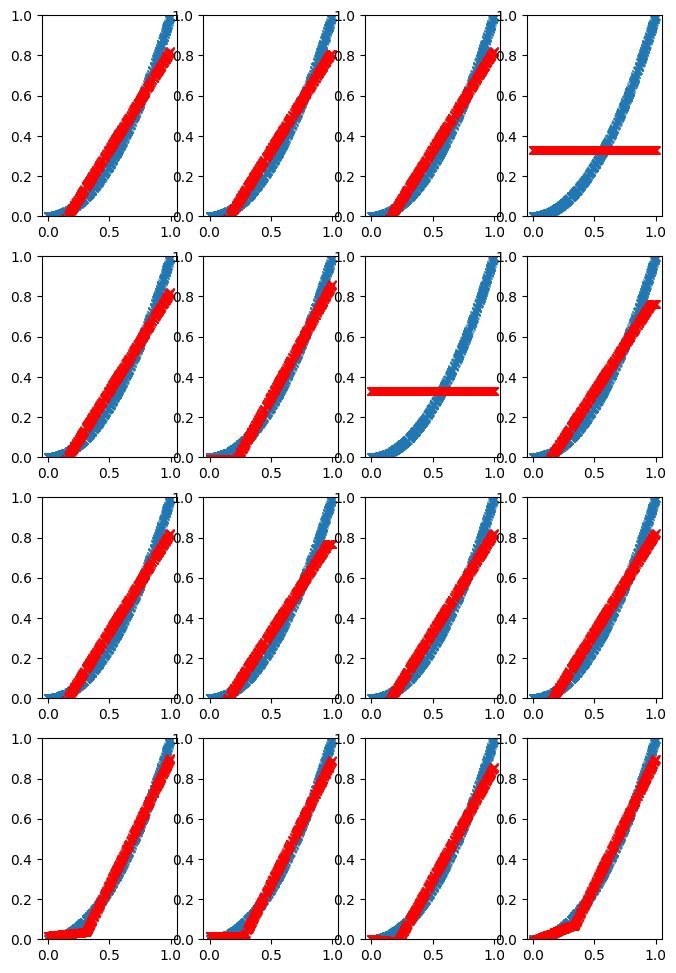

In [ ]:
plot_tests(roster, X_TEST)

In [ ]:
roster = active_learning(16,4,EPOCHS)

Epoch 0, Shared Loss: 0.12739276885986328
Epoch 0, Shared Loss: 0.1444721817970276
Epoch 0, Shared Loss: 0.1318102329969406
Epoch 0, Shared Loss: 0.06399215012788773
Epoch 100, Shared Loss: 0.0030473493970930576
Epoch 100, Shared Loss: 0.005677088629454374
Epoch 100, Shared Loss: 0.008116571232676506
Epoch 100, Shared Loss: 0.006446836981922388
Epoch 200, Shared Loss: 0.0013345852494239807
Epoch 200, Shared Loss: 0.002372155198827386
Epoch 200, Shared Loss: 0.0019371933303773403
Epoch 200, Shared Loss: 0.005661414470523596
Epoch 300, Shared Loss: 0.0010701692663133144
Epoch 300, Shared Loss: 0.00047685796744190156
Epoch 300, Shared Loss: 0.0011480310931801796
Epoch 300, Shared Loss: 0.005654217675328255
Epoch 400, Shared Loss: 0.0010578518267720938
Epoch 400, Shared Loss: 0.00036626518703997135
Epoch 400, Shared Loss: 0.001061100047081709
Epoch 400, Shared Loss: 0.005651135928928852
Epoch 500, Shared Loss: 0.0010576744098216295
Epoch 500, Shared Loss: 0.0002765414828900248
Epoch 500, S

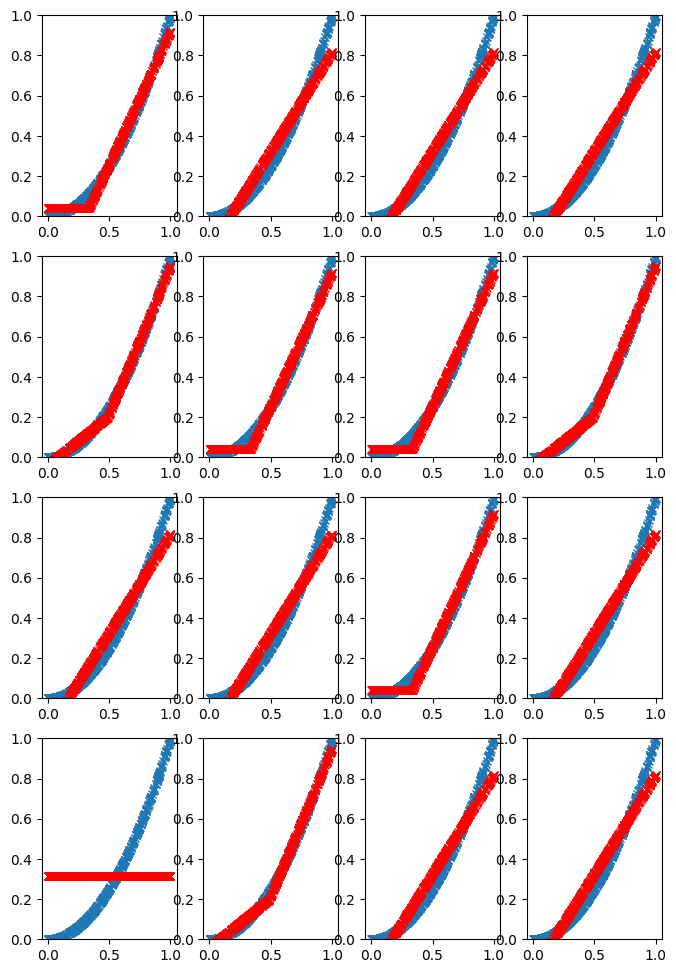

In [ ]:
plot_tests(roster,X_TEST)